# LSTM Modeling

In [1]:
## 필요한 모듈 호출 ##
try:
    %matplotlib inline
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    import pandas as pd
    from pandas.tseries.offsets import DateOffset
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from keras.layers import LSTM, Dense, Dropout
    from keras.models import Sequential
    import keras.backend as K
    from keras.callbacks import EarlyStopping
except ModuleNotFoundError:
    !pip install pandas==1.4.3
    !pip install numpy==1.22.4
    !pip install matplotlib==3.2.1
    !pip install scikit-learn==1.1.1
    !pip install keras==2.10.0
    %matplotlib inline
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    import pandas as pd
    from pandas.tseries.offsets import DateOffset
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from keras.layers import LSTM, Dense, Dropout
    from keras.models import Sequential
    import keras.backend as K
    from keras.callbacks import EarlyStopping

2022-11-25 04:44:04.146628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


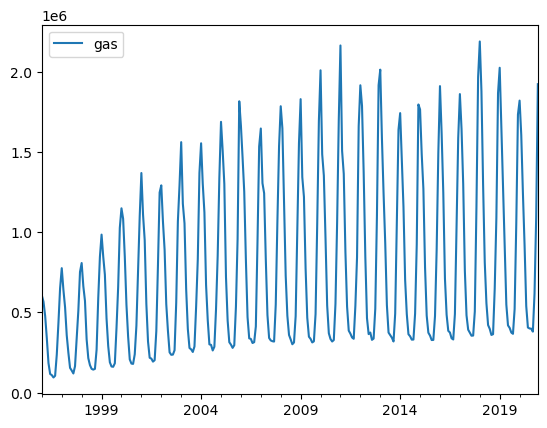

In [2]:
## 민수용 데이터 불러오기 ##
#제공된 데이터 파일(월별공급량및비중) 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능
data = pd.read_csv('월별공급량및비중.csv')
civil = data["도시가스(톤)_민수용"]
civil.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
civil = civil.to_frame()
civil.columns=['gas']
civil.index = pd.DatetimeIndex(civil.index.values,
                               freq=civil.index.inferred_freq)
civil.plot()

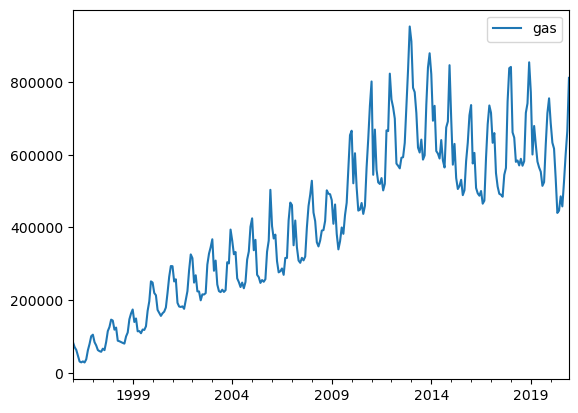

In [3]:
## 산업용 데이터 불러오기 ##
ind = data["도시가스(톤)_산업용"]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = ind.to_frame()
ind.columns=['gas']
ind.index = pd.DatetimeIndex(ind.index.values,
                               freq=ind.index.inferred_freq)
ind.plot()

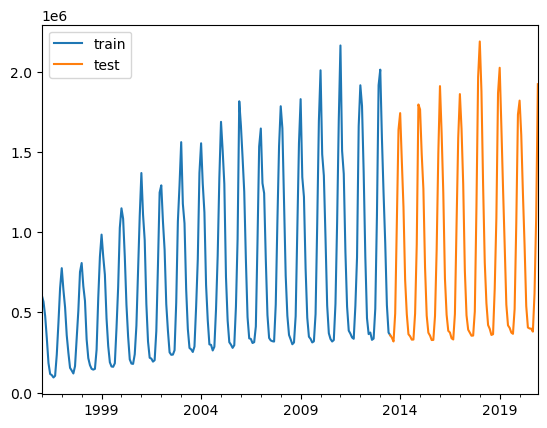

In [4]:
## train-test 데이터 분리 (민수용: 변수 앞에 c) ##
split_date = pd.Timestamp('07-01-2013') #월-일-년 / rate : 0.3
ctrain = civil.loc[:split_date]
ctest = civil.loc[split_date:]

ax = ctrain.plot()
ctest.plot(ax=ax)
plt.legend(['train', 'test'])

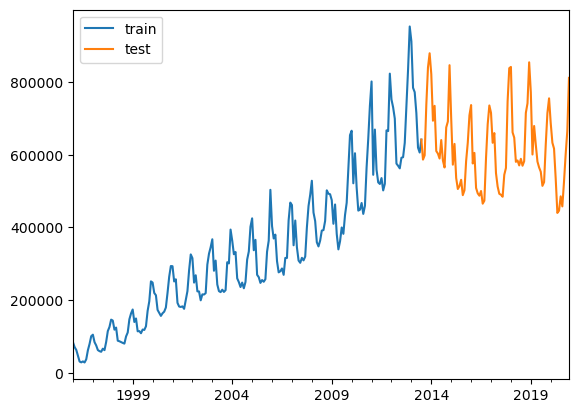

In [5]:
## train-test 데이터 분리 (산업용: 변수 앞에 i) ##
split_date = pd.Timestamp('07-01-2013') #월-일-년 / rate : 0.3
itrain = ind.loc[:split_date]
itest = ind.loc[split_date:]

ax = itrain.plot()
itest.plot(ax=ax)
plt.legend(['train', 'test'])

In [6]:
## 민수용 데이터 전처리 ##
#Scaling
sc1 = MinMaxScaler()
train_sc = sc1.fit_transform(ctrain)
test_sc = sc1.transform(ctest)

#DataFrame으로 바꿈
ctrain_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=ctrain.index)
ctest_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=ctest.index)

#12번 shift (1년의 주기성을 가지므로)
for s in range(1, 13):
    ctrain_sc_df['shift_{}'.format(s)] = ctrain_sc_df['Scaled'].shift(s)
    ctest_sc_df['shift_{}'.format(s)] = ctest_sc_df['Scaled'].shift(s)

#X, Y 분리 (기존 Scaled열을 Y로 하고 이를 제외한 나머지 shift한 열들을 X로 함)
X_train = ctrain_sc_df.dropna().drop('Scaled', axis=1)
Y_train = ctrain_sc_df.dropna()[['Scaled']]
X_test = ctest_sc_df.dropna().drop('Scaled', axis=1)
Y_test = ctest_sc_df.dropna()[['Scaled']]

#DataFrame에서 NumpyArray로 변경
X_train = X_train.values
X_test = X_test.values
cY_train = Y_train.values
cY_test = Y_test.values

#LSTM input형식에 맞게 reshape
cX_train_t = X_train.reshape(X_train.shape[0], 12, 1)
cX_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("CIVIL 최종 DATA")
print(cX_train_t.shape)
print(cX_train_t)
print(cY_train)

CIVIL 최종 DATA
(199, 12, 1)
[[[0.26913139]
  [0.16427444]
  [0.06892207]
  ...
  [0.18511893]
  [0.2280687 ]
  [0.24702465]]

 [[0.32924143]
  [0.26913139]
  [0.16427444]
  ...
  [0.1175476 ]
  [0.18511893]
  [0.2280687 ]]

 [[0.26403065]
  [0.32924143]
  [0.26913139]
  ...
  [0.04342227]
  [0.1175476 ]
  [0.18511893]]

 ...

 [[0.40450327]
  [0.55428509]
  [0.72175819]
  ...
  [0.13530805]
  [0.13063241]
  [0.17888072]]

 [[0.2177028 ]
  [0.40450327]
  [0.55428509]
  ...
  [0.1133435 ]
  [0.13530805]
  [0.13063241]]

 [[0.13523551]
  [0.2177028 ]
  [0.40450327]
  ...
  [0.11701175]
  [0.1133435 ]
  [0.13530805]]]
[[0.32924143]
 [0.26403065]
 [0.2116798 ]
 [0.12707007]
 [0.074283  ]
 [0.02895962]
 [0.0209475 ]
 [0.01208033]
 [0.03397379]
 [0.11493412]
 [0.20119106]
 [0.31797164]
 [0.34470323]
 [0.27504363]
 [0.23059416]
 [0.11468361]
 [0.05819152]
 [0.03710378]
 [0.02603904]
 [0.02360789]
 [0.02591089]
 [0.08361637]
 [0.23934477]
 [0.36323021]
 [0.43030099]
 [0.3642579 ]
 [0.30932743]
 

In [7]:
## 산업용 데이터 전처리 ##
#Scaling
sc2 = MinMaxScaler()
train_sc = sc2.fit_transform(itrain)
test_sc = sc2.transform(itest)

#DataFrame으로 바꿈
itrain_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=itrain.index)
itest_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=itest.index)

#12번 shift (1년의 주기성을 가지므로)
for s in range(1, 13):
    itrain_sc_df['shift_{}'.format(s)] = itrain_sc_df['Scaled'].shift(s)
    itest_sc_df['shift_{}'.format(s)] = itest_sc_df['Scaled'].shift(s)
    
#X, Y 분리 (기존 Scaled열을 Y로 하고 이를 제외한 나머지 shift한 열들을 X로 함)
X_train = itrain_sc_df.dropna().drop('Scaled', axis=1)
Y_train = itrain_sc_df.dropna()[['Scaled']]
X_test = itest_sc_df.dropna().drop('Scaled', axis=1)
Y_test = itest_sc_df.dropna()[['Scaled']]

#DataFrame에서 NumpyArray로 변경
X_train = X_train.values
X_test = X_test.values
iY_train = Y_train.values
iY_test = Y_test.values

#LSTM input형식에 맞게 reshape
iX_train_t = X_train.reshape(X_train.shape[0], 12, 1)
iX_test_t = X_test.reshape(X_test.shape[0], 12, 1)
print("IND 최종 DATA")
print(iX_train_t.shape)
print(iX_train_t)
print(iY_train)

IND 최종 DATA
(199, 12, 1)
[[[0.07820584]
  [0.05520819]
  [0.03649491]
  ...
  [0.03724932]
  [0.04565268]
  [0.06011619]]

 [[0.08270529]
  [0.07820584]
  [0.05520819]
  ...
  [0.02038639]
  [0.03724932]
  [0.04565268]]

 [[0.06048367]
  [0.08270529]
  [0.07820584]
  ...
  [0.00272474]
  [0.02038639]
  [0.03724932]]

 ...

 [[0.74231781]
  [0.80448215]
  [0.81757194]
  ...
  [0.60923019]
  [0.57774379]
  [0.58537545]]

 [[0.63940015]
  [0.74231781]
  [0.80448215]
  ...
  [0.61102435]
  [0.60923019]
  [0.57774379]]

 [[0.62485449]
  [0.63940015]
  [0.74231781]
  ...
  [0.65357724]
  [0.61102435]
  [0.60923019]]]
[[0.08270529]
 [0.06048367]
 [0.05074225]
 [0.03695534]
 [0.03370856]
 [0.03184739]
 [0.04113378]
 [0.03668945]
 [0.06091924]
 [0.09338269]
 [0.10562188]
 [0.12754411]
 [0.12477289]
 [0.09769191]
 [0.10387635]
 [0.06482747]
 [0.06312843]
 [0.06060688]
 [0.05826475]
 [0.05616039]
 [0.07742981]
 [0.0891621 ]
 [0.12848118]
 [0.14584452]
 [0.15766868]
 [0.1205015 ]
 [0.13100273]
 [0

In [8]:
K.clear_session()

## 민수용 LSTM모델 생성 ##
cmodel = Sequential()
cmodel.add(LSTM(300, input_shape=cX_train_t.shape[1:], return_sequences=True, activation='relu'))
cmodel.add(Dropout(0.2))
cmodel.add(LSTM(300, activation='relu'))
cmodel.add(Dense(1))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
print(cmodel.summary())

## 산업용 LSTM모델 생성 ##
imodel = Sequential()
imodel.add(LSTM(300, input_shape=iX_train_t.shape[1:], return_sequences=True, activation='relu'))
imodel.add(Dropout(0.2))
imodel.add(LSTM(300, activation='relu'))
imodel.add(Dense(1))
imodel.compile(loss='mean_squared_error', optimizer='adam')
print(imodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 300)           362400    
                                                                 
 dropout (Dropout)           (None, 12, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)     

In [9]:
## 민수용 모델 fitting ##
early_stop = EarlyStopping(monitor='loss', patience=40, verbose=1)
ch = cmodel.fit(cX_train_t, cY_train, epochs=300, validation_data=[cX_test_t, cY_test],
         batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/300
20/20 [==============================] - 5s 80ms/step - loss: 0.0846 - val_loss: 0.1004
Epoch 2/300
20/20 [==============================] - 1s 43ms/step - loss: 0.0636 - val_loss: 0.0843
Epoch 3/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0515 - val_loss: 0.0555
Epoch 4/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0299 - val_loss: 0.0190
Epoch 5/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0142 - val_loss: 0.0081
Epoch 6/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 7/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 8/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 9/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0047 - val_loss: 0.0187
Epoch 10/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0074 - val_loss: 0.0033

20/20 [==============================] - 1s 39ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 83/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 84/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 85/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 86/300
20/20 [==============================] - 1s 38ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 87/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 88/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 89/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 90/300
20/20 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 91/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0016 - val_loss: 0.0019
Epo

Minimum Train Loss: 0.0014
Minimum Validation Loss: 0.0015


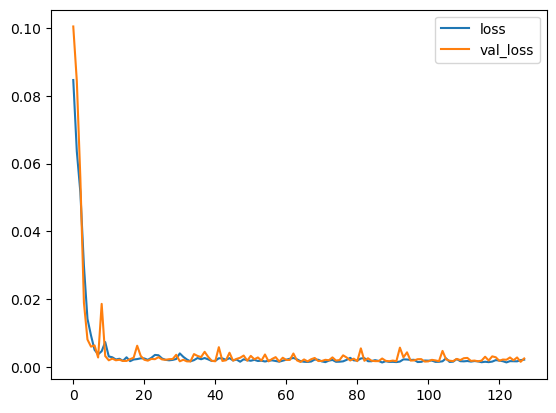

In [10]:
## 민수용 loss와 validation loss 비교 ##
history_df=pd.DataFrame(ch.history)
print("Minimum Train Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

plt.plot(ch.history['loss'])
plt.plot(ch.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [11]:
## 산업용 모델 fitting ##
early_stop = EarlyStopping(monitor='loss', patience=40, verbose=1)
ih = imodel.fit(iX_train_t, iY_train, epochs=300, validation_data=[iX_test_t, iY_test],
         batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/300
20/20 [==============================] - 4s 64ms/step - loss: 0.0464 - val_loss: 0.0234
Epoch 2/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0089 - val_loss: 0.0228
Epoch 3/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0075 - val_loss: 0.0143
Epoch 4/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 5/300
20/20 [==============================] - 1s 43ms/step - loss: 0.0068 - val_loss: 0.0124
Epoch 6/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0063 - val_loss: 0.0124
Epoch 7/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0073 - val_loss: 0.0122
Epoch 8/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0068 - val_loss: 0.0126
Epoch 9/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 10/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0058 - val_loss: 0.0164

20/20 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 83/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 0.0144
Epoch 84/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 85/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 86/300
20/20 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 87/300
20/20 [==============================] - 1s 43ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 88/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0013 - val_loss: 0.0226
Epoch 89/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0015 - val_loss: 0.0113
Epoch 90/300
20/20 [==============================] - 1s 42ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 91/300
20/20 [==============================] - 1s 41ms/step - loss: 0.0014 - val_loss: 0.0074
Epo

Minimum Train Loss: 0.0012
Minimum Validation Loss: 0.0041


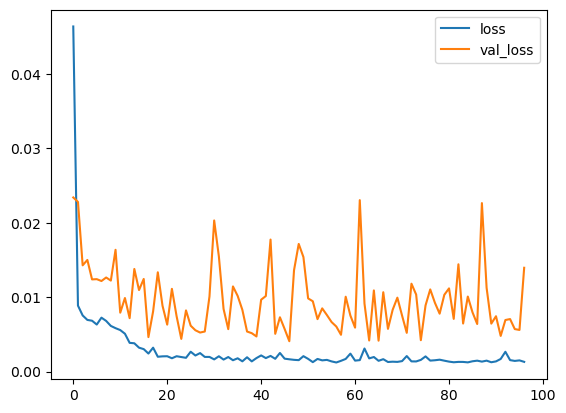

In [12]:
## 산업용 loss와 validation loss 비교 ##
history_df=pd.DataFrame(ih.history)
print("Minimum Train Loss: {:0.4f}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

plt.plot(ih.history['loss'])
plt.plot(ih.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [13]:
## 민수용 y값 예측 및 평가 ##
cY_pred = cmodel.predict(cX_test_t)
print("CIVIL Loss: ", cmodel.evaluate(cX_test_t, cY_test))

## 산업용 y값 예측 및 평가 ##
iY_pred = imodel.predict(iX_test_t)
print("IND Loss: ", imodel.evaluate(iX_test_t, iY_test))

3/3 [==============================] - 0s 7ms/step - loss: 0.0026
CIVIL Loss:  0.002572268946096301
3/3 [==============================] - 0s 7ms/step - loss: 0.0140
IND Loss:  0.013954376801848412


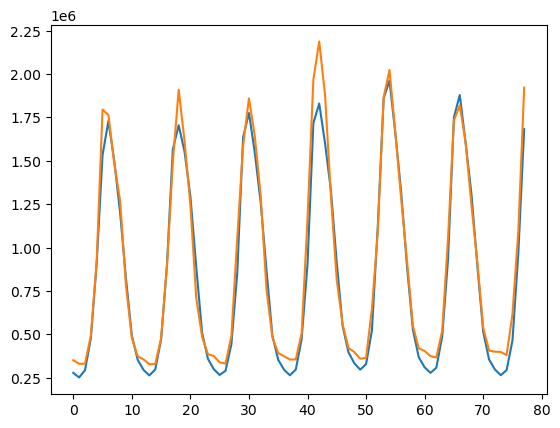

In [14]:
## 모델 Evaluation - 민수용 y값 예측값과 기존값(y test값) 비교 ##
cy_pred = sc1.inverse_transform(cY_pred)
cy_test = sc1.inverse_transform(cY_test)
plt.figure()
plt.plot(cy_pred)
plt.plot(cy_test)

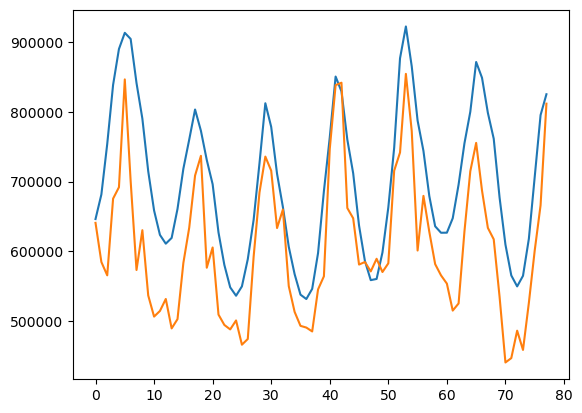

In [15]:
## 모델 Evaluation - 산업용 y값 예측값과 기존값(y test값) 비교 ##
iy_pred = sc2.inverse_transform(iY_pred)
iy_test = sc2.inverse_transform(iY_test)
plt.figure()
plt.plot(iy_pred)
plt.plot(iy_test)

In [16]:
## 민수용과 산업용 모델 저장 ##
cmodel.save('lstm_civil.h5')
imodel.save('lstm_ind.h5')